In [2]:
"""
Part 3.B
"""
import re
import numpy as np
import matplotlib.pyplot as plt

np.seterr(divide='ignore')

def load_data(filename):
    dat = []
    with open(filename) as file:
        rows = file.readlines()
        for row in rows:
            row = row.replace('\n', '')
            row = re.sub('\s+', ' ', row)
            row = row.split(' ')
            dat.append((float(row[1]), float(row[2])))

    dat = np.array(dat)
    return dat
    
data = load_data('p3_data/old_faithful.txt')

plt.clf()
xs = [x for x,_ in data]
ys = [y for _,y in data]
plt.scatter(xs, ys)
plt.xlabel('Eruption Time')
plt.ylabel('Waiting Time')

Text(0,0.5,'Waiting Time')

In [3]:
"""
Part 3.C
"""
import random
from scipy.stats import norm

def gaussian_prob(point, mu, sig):
    p = norm.pdf(point[0], mu[0], sig[0][0])
    p *= norm.pdf(point[1], mu[1], sig[1][1])
    return p

def assign_points(data, mu1, mu2, s1, s2):
    ret = []
    for d in data:
        p1 = gaussian_prob(d, mu1, s1)
        p2 = gaussian_prob(d, mu2, s2)
        ret.append(0 if p1 > p2 else 1)
    
    return ret

def create_guesses(data):
    mu1 = data[random.randint(0, len(data)-1)]
    mu2 = data[random.randint(0, len(data)-1)]
    s1 = np.array([[random.random()+1, 0],
                   [0, random.random()+1]])
    s2 = np.array([[random.random()+1,0],
                   [0,random.random()+1]])
    guesses = assign_points(data, mu1, mu2, s1, s2)
    count = len([i for i in guesses if i == 0])
    pi = float(count) / data.shape[0]
    
    return mu1, mu2, s1, s2, pi

from sklearn.cluster import KMeans
def k_means_guesses(data):
    km = KMeans(n_clusters=2).fit(data)
    labels = km.labels_
    
    # separate the data
    data0 = []
    data1 = []
    for i in range(len(labels)):
        if labels[i] == 0:
            data0.append(data[i])
        else:
            data1.append(data[i])
    data0 = np.array(data0)
    data1 = np.array(data1)
    
    # get mean
    mu1 = np.mean(data0, axis=0)
    mu2 = np.mean(data1, axis=0)
    
    # get variance
    s1 = np.diag(np.var(data0, axis=0))
    s2 = np.diag(np.var(data1, axis=0))
    
    # calculate pi
    pi = len(data0) / len(labels)
    
    return mu1, mu2, s1, s2, pi

def e_step(data, mu1, mu2, s1, s2, pi):
    ys = []
    for d in data:
        pr1 = gaussian_prob(d, mu1, s2)
        pr2 = gaussian_prob(d, mu2, s2)
        numer = pi * pr2
        denom = (1-pi)*pr1 + pi*pr2
        if denom == 0: denom = 0.00001
        ys.append(numer/denom)
    return np.array(ys)

def m_step(data, mu1, mu2, ys):
    mu1_num = 0
    mu1_denom = 0
    mu2_num = 0
    mu2_denom = 0
    s1_num = 0
    s1_denom = 0
    s2_num = 0
    s2_denom = 0
    pi = 0
    for i in range(len(ys)):
        mu1_num += ((1-ys[i])*data[i])
        mu1_denom += (1-ys[i])
        
        mu2_num += (ys[i]*data[i])
        mu2_denom += (ys[i])
        
        v1 = (data[i] - mu1).reshape((2,1))
        s1_num += ((1.0-ys[i])*(v1.dot(v1.T)))
        s1_denom += (1.0-ys[i])
        
        v2 = (data[i]-mu2).reshape((2,1))
        s2_num += (ys[i]*(v2.dot(v2.T)))
        s2_denom += ys[i]
        
        pi += (ys[i]/float(len(ys)))
        
    if mu1_denom == 0: mu1_denom = 0.00001
    if mu2_denom == 0: mu2_denom = 0.00001
    if s1_denom == 0: s1_denom = 0.00001
    if s2_denom == 0: s2_denom = 0.00001

        
    mu1 = mu1_num / mu1_denom
    mu2 = mu2_num / mu2_denom
    s1 = s1_num / s1_denom
    s2 = s2_num / s2_denom
    
    return np.array(mu1), np.array(mu2), np.array(s1), np.array(s2), pi

def plot_trajectories(data, mu1s, mu2s):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    xs = [x for x,_ in data]
    ys = [y for _,y in data]
    mu1xs = [x for x,_ in mu1s]
    mu1ys = [y for _,y in mu1s]
    mu2xs = [x for x,_ in mu2s]
    mu2ys = [y for _,y in mu2s]
    ax1.scatter(xs, ys, c='blue', label='data')
    ax1.scatter(mu1xs, mu1ys, c='r', label='Mean 1')
    ax1.scatter(mu2xs, mu2ys, c='g', label='Mean 2')
    plt.legend(loc='upper left')
    plt.show()
    
    plt.clf()
    iterations = [i for i in range(len(mu1s))]
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(iterations, mu1xs, label='Mean 1 X')
    ax1.plot(iterations, mu1ys, label='Mean 1 Y')
    ax1.plot(iterations, mu2xs, label='Mean 2 X')
    ax1.plot(iterations, mu2ys, label='Mean 2 Y')
    plt.legend(loc='upper left')
    plt.show()
    

In [4]:
def generate_GMM(plot, random_guesses=True):
    mu1, mu2, s1, s2, pi = create_guesses(data) if random_guesses else k_means_guesses(data)
    epsilon = 0.0001

    difs = 100
    iteration = 0
    mu1s = [mu1]
    mu2s = [mu2]
    while difs > epsilon:
        ys = e_step(data, mu1, mu2, s1, s2, pi)
        params = m_step(data, mu1, mu2, ys)
        difs = 0
        for p in ((mu1, params[0]), (mu2, params[1]), (s1, params[2]), (s2, params[3]), (pi, params[4])):
            difs += np.linalg.norm(p[0]-p[1])
        mu1, mu2, s1, s2, pi = params
        mu1s.append(mu1)
        mu2s.append(mu2)
        iteration += 1

    if plot: plot_trajectories(data, mu1s, mu2s)
    return iteration

<Figure size 432x288 with 0 Axes>

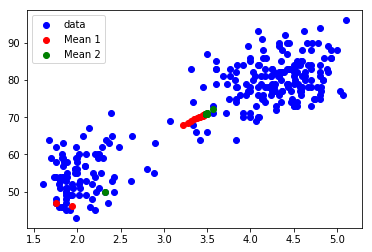

<Figure size 432x288 with 0 Axes>

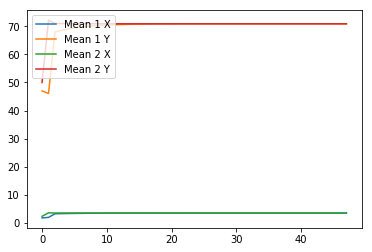

47

In [5]:
generate_GMM(True)

In [6]:
iterations = []
for i in range(50):
    iterations.append(generate_GMM(False))

(array([ 1., 18.,  7.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.,
         5.,  4.,  4.,  2.]),
 array([ 2.        ,  3.53333333,  5.06666667,  6.6       ,  8.13333333,
         9.66666667, 11.2       , 12.73333333, 14.26666667, 15.8       ,
        17.33333333, 18.86666667, 20.4       , 21.93333333, 23.46666667,
        25.        , 26.53333333, 28.06666667, 29.6       , 31.13333333,
        32.66666667, 34.2       , 35.73333333, 37.26666667, 38.8       ,
        40.33333333, 41.86666667, 43.4       , 44.93333333, 46.46666667,
        48.        ]),
 <a list of 30 Patch objects>)

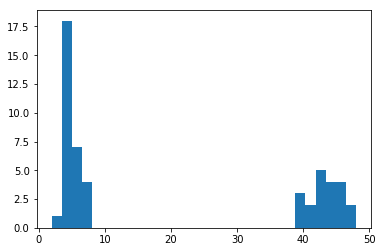

In [7]:
plt.clf()
plt.hist(iterations, 30)

<Figure size 432x288 with 0 Axes>

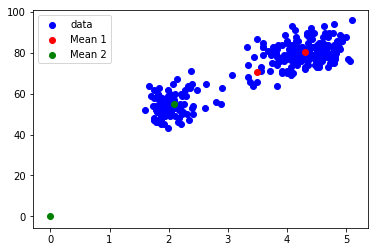

<Figure size 432x288 with 0 Axes>

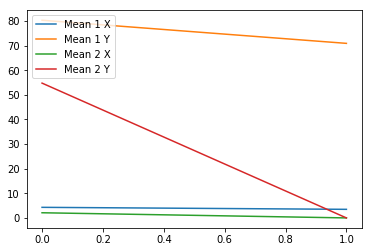

2

In [8]:
"""
Part 3.D
"""
generate_GMM(True, False)

In [9]:
iterations = []
for i in range(50):
    iterations.append(generate_GMM(False, False))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([1.5       , 1.53333333, 1.56666667, 1.6       , 1.63333333,
        1.66666667, 1.7       , 1.73333333, 1.76666667, 1.8       ,
        1.83333333, 1.86666667, 1.9       , 1.93333333, 1.96666667,
        2.        , 2.03333333, 2.06666667, 2.1       , 2.13333333,
        2.16666667, 2.2       , 2.23333333, 2.26666667, 2.3       ,
        2.33333333, 2.36666667, 2.4       , 2.43333333, 2.46666667,
        2.5       ]),
 <a list of 30 Patch objects>)

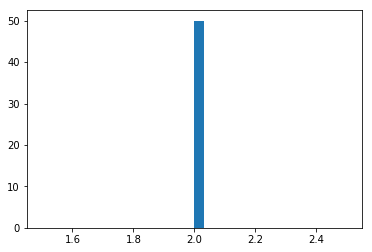

In [10]:
plt.clf()
plt.hist(iterations, 30)